In [1]:
import torch
import numpy as np
from abcpy.output import Journal
import matplotlib.pyplot as plt
import pickle
from src.models.lorenz_96_model import Lorenz96SDE
from src.scoring_rules.scoring_rules import EnergyScore
from tqdm import tqdm
from scipy.stats import gaussian_kde
import matplotlib as mpl

/home/minny/anaconda3/envs/GBLFI-final/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
params = {
   'text.usetex': False,
   'figure.figsize': [6.4, 4],
    'font.size': 9,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'legend.title_fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
   }

In [3]:
ss_abc_ss = Journal.fromFile('./SMC_ABC_SS/ABC_n-steps_25_n-samples_1000_n-sam-per-param_10_ss.jnl')
ss_abc_noss = Journal.fromFile('./SMC_ABC/ABC_n-steps_25_n-samples_1000_n-sam-per-param_10_nops.jnl')


ss_abc_ss = np.array(ss_abc_ss.get_accepted_parameters()).reshape(1000,3)
ss_abc_noss = np.array(ss_abc_noss.get_accepted_parameters()).reshape(1000,3)

In [4]:
with open('sgnht_stoch_l96_m_10.pickle', 'rb') as handle:
    ss_sgnht = pickle.load(handle)

trans = ss_sgnht['config']['transformer']
ss_sgnht_con = trans.inverse_transform(ss_sgnht['samples_uncon'], use_torch=True)

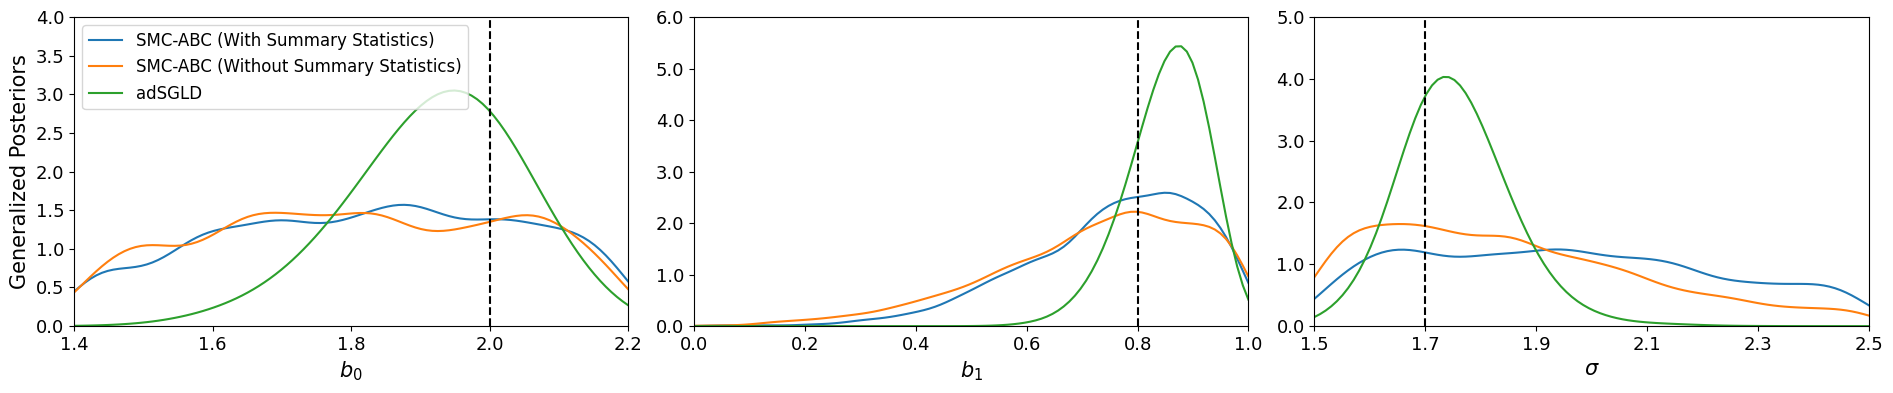

In [5]:
from matplotlib.ticker import FormatStrFormatter

y_maxes = [4.0,6,5]
with mpl.rc_context(params):
    smoothing = 0.2
    prior_lims = [(1.4,2.2),(0,1),(1.5,2.5)]
    true = [2,0.8,1.7]
    xlab_leg = [r'$b_{0}$', r'$b_{1}$', r'$\sigma$']
    fig, axs = plt.subplots(ncols=3,nrows=1, figsize=(19,4))

    for ax_idx in range(3):
        axs[ax_idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        post_samples = ss_abc_ss[:, ax_idx]
        xmin, xmax = prior_lims[ax_idx][0], prior_lims[ax_idx][1]
        positions = np.linspace(xmin, xmax, 100)
        gaussian_kernel = gaussian_kde(post_samples)
        gaussian_kernel.covariance_factor = lambda : smoothing
        gaussian_kernel._compute_covariance()

        axs[ax_idx].plot(positions, gaussian_kernel(positions), label="SMC-ABC (With Summary Statistics)")

        post_samples = ss_abc_noss[:, ax_idx]
        xmin, xmax = prior_lims[ax_idx][0], prior_lims[ax_idx][1]
        positions = np.linspace(xmin, xmax, 100)
        gaussian_kernel = gaussian_kde(post_samples)
        gaussian_kernel.covariance_factor = lambda : smoothing
        gaussian_kernel._compute_covariance()

        axs[ax_idx].plot(positions, gaussian_kernel(positions), label="SMC-ABC (Without Summary Statistics)")

        post_samples = ss_sgnht_con[5000:, ax_idx].numpy()
        xmin, xmax = prior_lims[ax_idx][0], prior_lims[ax_idx][1]
        positions = np.linspace(xmin, xmax, 100)
        gaussian_kernel = gaussian_kde(post_samples)
        gaussian_kernel.covariance_factor = lambda : 0.5
        gaussian_kernel._compute_covariance()

        axs[ax_idx].plot(positions, gaussian_kernel(positions), label="adSGLD") #Use to be SG-NHT


        axs[ax_idx].set_xlim(prior_lims[ax_idx])
        if ax_idx ==0:
            axs[ax_idx].set_ylabel('Generalized Posteriors') 
        else:
            axs[ax_idx].set_ylabel('') 
        axs[ax_idx].axvline(x=true[ax_idx], color='k', linestyle='--')
        axs[ax_idx].set_ylim(ymin=0, ymax=y_maxes[ax_idx])
        axs[ax_idx].set_xlabel(xlab_leg[ax_idx])
        axs[ax_idx].get_xaxis().set_ticks(np.arange(prior_lims[ax_idx][0], prior_lims[ax_idx][1]+0.1, 0.2))
    axs[0].legend(loc='upper left')
    
    
    plt.tight_layout()
    #plt.show()
    plt.savefig("Marginal Posterior Linear Lorenz (Combined).pdf", bbox_inches='tight')